# Work with spread timeseries
### Denisov Ilia

In [17]:
import numpy as np
import pylab as pl
import pandas as pd

import matplotlib.patches as mpatches
import seaborn as sns

from datetime import datetime as dtm
from collections import Counter, defaultdict
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
np.set_printoptions(precision=2, threshold=5)
import scipy as sp
import random
import scipy.stats
from itertools import cycle

%pylab inline
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


/home/denilv/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Analysis of timeseries

In [37]:
filepath = 'seeds/nba_timelines.csv'

In [38]:
df_raw = pd.read_csv(filepath)
df = df_raw.drop(['team_org', 'opponent_team_org'], axis=1)

df.head()

,casinoName,date,starttime,team,opponent_team,updateTime,spreadTeam,spreadOpponent
0,pinnacle,20120101,6:00p,BOS,WAS,01/01 06:07 PM,-7 +100,+7 -110
1,pinnacle,20120101,6:00p,BOS,WAS,01/01 06:04 PM,-7 -103,+7 -107
2,pinnacle,20120101,6:00p,BOS,WAS,01/01 06:03 PM,-6.5 -110,+6.5 +100
3,pinnacle,20120101,6:00p,BOS,WAS,01/01 06:03 PM,-6.5 -109,+6.5 -101
4,pinnacle,20120101,6:00p,BOS,WAS,01/01 05:43 PM,-6.5 -110,+6.5 +100


In [39]:
#correct data_datetmie column (invalid year)
new_data_datetime = []
for d, data in zip(df.date, df.updateTime):
    year = str(d)[:4]
    if str(d)[4:] == '0101' and data[:5] == '12/31':
        year = str(int(year) - 1)
    new_time = dtm.strptime(data[6:], '%I:%M %p').strftime('%H:%M')
    new_date = data[3:5] + '/' + data[:2] + '/' + year + ' ' + new_time
    new_data_datetime.append(new_date)
df['updateTime'] = new_data_datetime
df.head()

,casinoName,date,starttime,team,opponent_team,updateTime,spreadTeam,spreadOpponent
0,pinnacle,20120101,6:00p,BOS,WAS,01/01/2012 18:07,-7 +100,+7 -110
1,pinnacle,20120101,6:00p,BOS,WAS,01/01/2012 18:04,-7 -103,+7 -107
2,pinnacle,20120101,6:00p,BOS,WAS,01/01/2012 18:03,-6.5 -110,+6.5 +100
3,pinnacle,20120101,6:00p,BOS,WAS,01/01/2012 18:03,-6.5 -109,+6.5 -101
4,pinnacle,20120101,6:00p,BOS,WAS,01/01/2012 17:43,-6.5 -110,+6.5 +100


In [40]:
#add 24-hour formatted time
new_times = []
for i in df.starttime:
    spl = i.split(':')
    h = spl[0]
    m = spl[1][:-1]
    if i[-1] == 'p' and h!='12':
        
        tmp = 12+int(h)
        hour = '00' if tmp == 24 else tmp
        s = str(hour) + ':' + m
        new_times.append(s)
    else:
        new_times.append(i[:-1])        
# df['start_dt'] = new_times

new_dates = []
for i in df.date:
    d = dtm.strptime(str(i), '%Y%m%d')
    new_dates.append(d.strftime('%d/%m/%Y'))
    
new_start_dt = np.core.defchararray.add(np.core.defchararray.add(new_dates, [' '] * len(new_times)), new_times)
df['date'] = new_start_dt
df.head()

,casinoName,date,starttime,team,opponent_team,updateTime,spreadTeam,spreadOpponent
0,pinnacle,01/01/2012 18:00,6:00p,BOS,WAS,01/01/2012 18:07,-7 +100,+7 -110
1,pinnacle,01/01/2012 18:00,6:00p,BOS,WAS,01/01/2012 18:04,-7 -103,+7 -107
2,pinnacle,01/01/2012 18:00,6:00p,BOS,WAS,01/01/2012 18:03,-6.5 -110,+6.5 +100
3,pinnacle,01/01/2012 18:00,6:00p,BOS,WAS,01/01/2012 18:03,-6.5 -109,+6.5 -101
4,pinnacle,01/01/2012 18:00,6:00p,BOS,WAS,01/01/2012 17:43,-6.5 -110,+6.5 +100


In [41]:
df = df.rename(columns={'date':'start_dt', 'updateTime':'update_dt', 'casinoName':'casino'})
df = df.drop('starttime', axis=1)
df.head()

,casino,start_dt,team,opponent_team,update_dt,spreadTeam,spreadOpponent
0,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:07,-7 +100,+7 -110
1,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:04,-7 -103,+7 -107
2,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:03,-6.5 -110,+6.5 +100
3,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:03,-6.5 -109,+6.5 -101
4,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 17:43,-6.5 -110,+6.5 +100


In [42]:
#add start timestamp
start_ts = []
for i in df.start_dt:
    start_ts.append(int(dtm.strptime(i, '%d/%m/%Y %H:%M').timestamp()))
df['start_ts'] = start_ts
df.head()

#add update timestamp
update_ts = []
for i in df.update_dt:
    update_ts.append(int(dtm.strptime(i, '%d/%m/%Y %H:%M').timestamp()))
df['update_ts'] = update_ts
df.head()

,casino,start_dt,team,opponent_team,update_dt,spreadTeam,spreadOpponent,start_ts,update_ts
0,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:07,-7 +100,+7 -110,1325426400,1325426820
1,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:04,-7 -103,+7 -107,1325426400,1325426640
2,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:03,-6.5 -110,+6.5 +100,1325426400,1325426580
3,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:03,-6.5 -109,+6.5 -101,1325426400,1325426580
4,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 17:43,-6.5 -110,+6.5 +100,1325426400,1325425380


In [43]:
#split spreads and coef.
spreads = []
for i in df.spreadTeam:
    s = i.split()[0]
    if s == 'PK':
        spread = 0.0
    else:
        spread = float(s)
    spreads.append(spread)

team_coef = []
opp_coef = []
for i, j in zip(df.spreadTeam, df.spreadOpponent):
    tc = int(i.split()[-1])
    oc = int(j.split()[-1])
    team_coef.append(tc)
    opp_coef.append(oc)
    
df['spreadTeam'] = spreads
df = df.rename(columns={'spreadTeam':'spread'})
df.insert(7, 'opponent_coef', opp_coef)
df.insert(7, 'team_coef', team_coef)
df = df.drop('spreadOpponent', axis=1)

In [44]:
df['diff_ts'] = df.start_ts - df.update_ts

In [46]:
#drop zero moneylines
df = df[df.team_coef != 0]
df = df[df.opponent_coef != 0]
#add coefficients instead of moneylines
# df = df.drop(['k1', 'k2'], axis=1)
k1 = []
for i in df.team_coef:
    if i < 0:
        k1.append((-i + 100)/100)
    elif i > 0:
        k1.append((i + 100)/i)
    else:
        print(i)
        
k2 = []
for i in  df.opponent_coef:
    if i < 0:
        k2.append((-i + 100)/100)
    elif i > 0:
        k2.append((i + 100)/i)
    else:
        print(i)
        
df.insert(9, 'k2', k2)
df.insert(9, 'k1', k1)

In [47]:
df.head()

,casino,start_dt,team,opponent_team,update_dt,spread,team_coef,opponent_coef,start_ts,k1,k2,update_ts,diff_ts
0,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:07,-7.0,100,-110,1325426400,2.00,2.10,1325426820,-420
1,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:04,-7.0,-103,-107,1325426400,2.03,2.07,1325426640,-240
2,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:03,-6.5,-110,100,1325426400,2.10,2.00,1325426580,-180
3,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:03,-6.5,-109,-101,1325426400,2.09,2.01,1325426580,-180
4,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 17:43,-6.5,-110,100,1325426400,2.10,2.00,1325425380,1020


In [48]:
df.to_csv('nba_spread_movement.csv', index=False)

Load correct version of csv file.

In [49]:
filepath = 'nba_spread_movement.csv'
df = pd.read_csv(filepath)
df.head()

,casino,start_dt,team,opponent_team,update_dt,spread,team_coef,opponent_coef,start_ts,k1,k2,update_ts,diff_ts
0,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:07,-7.0,100,-110,1325426400,2.00,2.10,1325426820,-420
1,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:04,-7.0,-103,-107,1325426400,2.03,2.07,1325426640,-240
2,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:03,-6.5,-110,100,1325426400,2.10,2.00,1325426580,-180
3,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 18:03,-6.5,-109,-101,1325426400,2.09,2.01,1325426580,-180
4,pinnacle,01/01/2012 18:00,BOS,WAS,01/01/2012 17:43,-6.5,-110,100,1325426400,2.10,2.00,1325425380,1020


In [50]:
games = df.groupby(['start_dt', 'team', 'opponent_team'])
l = list(games.groups.keys())

Game params: ('07/05/2016 19:30', 'GSW', 'POR')


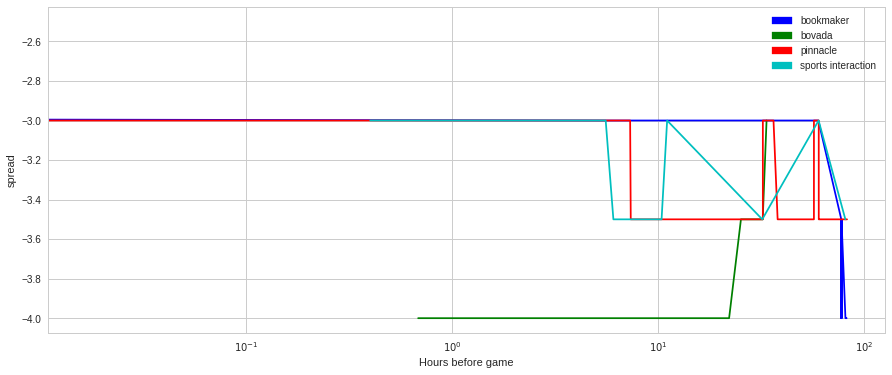

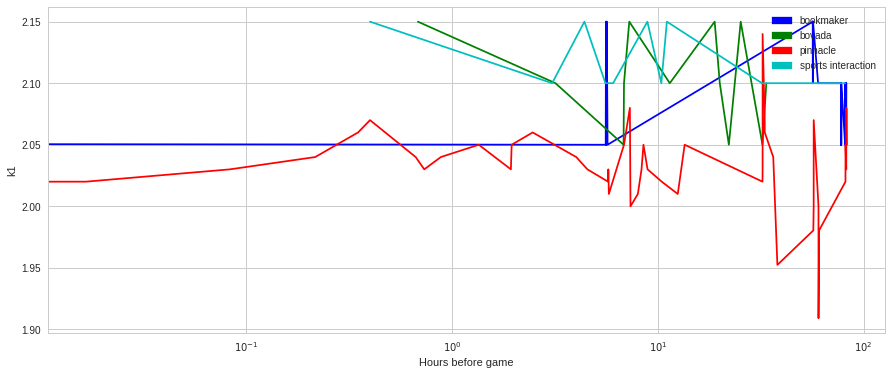

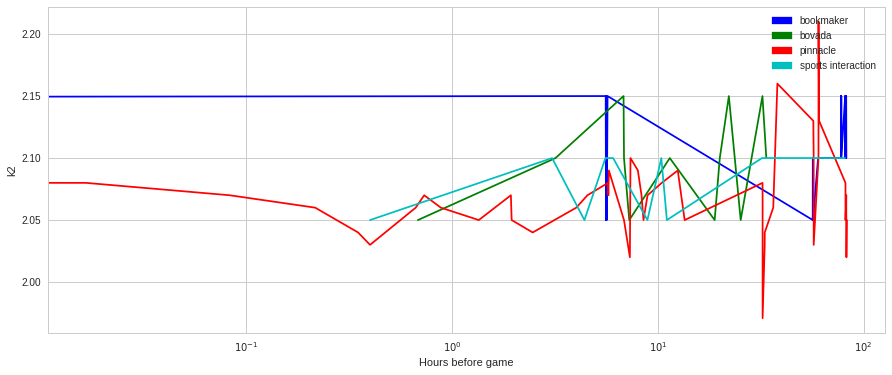

In [147]:
key = l[np.random.randint(len(l))]
print('Game params:',key)
game = games.get_group(key)
groups_by_casino = game.groupby('casino')
colors = 'bgrcmk'

for j, f in enumerate(['spread', 'k1', 'k2']):
    patches = []
    plt.figure(j, figsize=(15,6))
    pl.xlabel('Hours before game')
    pl.ylabel(f)
    for i, casino in enumerate(groups_by_casino.groups.keys()):
        tmp = groups_by_casino.get_group(casino)
        color = colors[i]
        pl.plot(tmp.diff_ts/3600, tmp[f], c=color)
        pl.xscale('log')
        patch = mpatches.Patch(color=color, label=casino)
        patches.append(patch)
    plt.legend(handles=patches, loc=1)
    pl.show()


In [126]:
data = defaultdict(lambda : defaultdict(lambda : []))
for name, game in games:
    groups_by_casino = game.groupby('casino')
    for casino, g in groups_by_casino:
        data['time_delta_spread'][casino].append(abs(g.spread.iloc[0] - g.spread.iloc[-1]))
        data['delta_spread'][casino].append(max(g.spread) - min(g.spread))
        data['min_spread'][casino].append(min(abs(g.spread)))
        data['max_spread'][casino].append(max(abs(g.spread))) 
        data['av_spread'][casino].append(np.average(g.spread))
        data['delta_team_coef'][casino].append(max(g.k1) - min(g.k1))
        data['delta_opp_coef'][casino].append(max(g.k2) - min(g.k2))
        data['av_team_coef'][casino].append(np.average(g.k1))
        data['av_opponent_coef'][casino].append(np.average(g.k2))
        data['min_team_coef'][casino].append(min(g.k1))
        data['min_opponent_coef'][casino].append(min(g.k2))
        data['max_team_coef'][casino].append(max(g.k1))
        data['max_opponent_coef'][casino].append(max(g.k2))

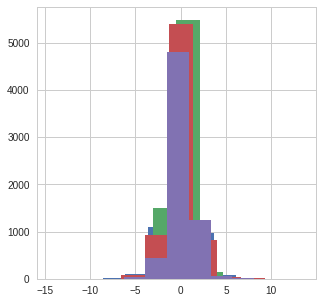

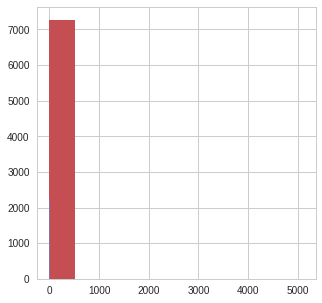

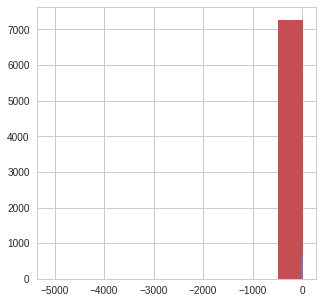

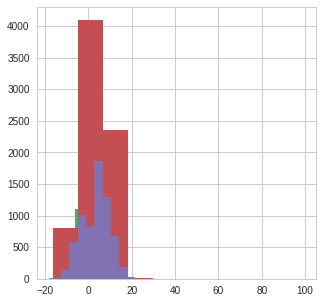

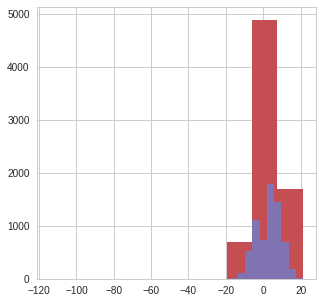

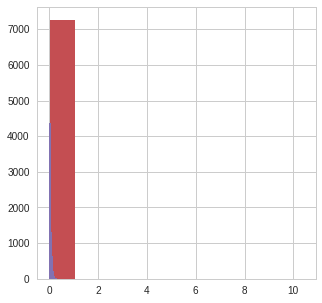

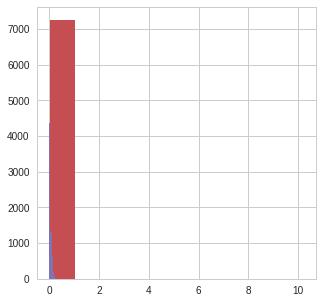

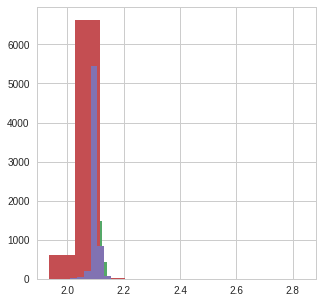

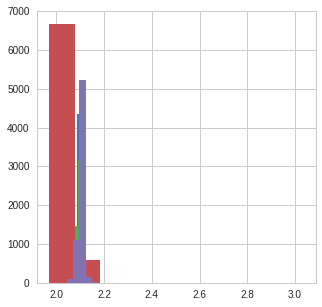

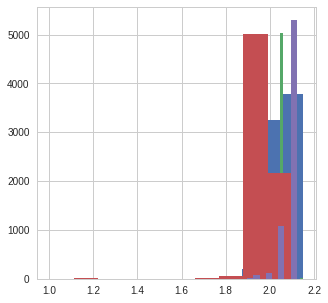

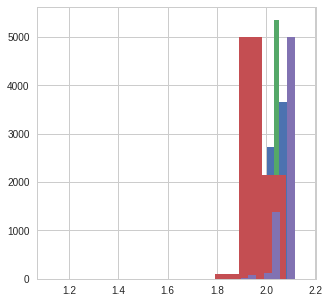

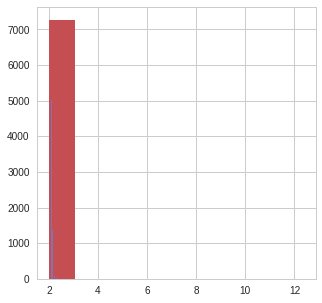

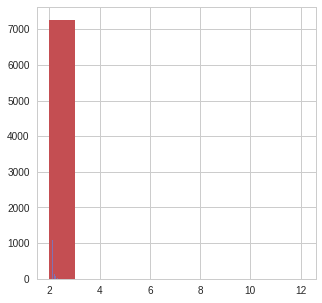

In [65]:
for i, (f_name, inf) in enumerate(data.items()):
#     print(i)
    for casino, nums in inf.items():
        pl.figure(i, figsize=(5,5))
        pl.hist(nums)

(array([ 1461.,  2413.,  1510., ...,    35.,    22.,    16.]),
 array([ 0. ,  0.5,  1. , ...,  5. ,  5.5,  6. ]),
 <a list of 12 Patch objects>)

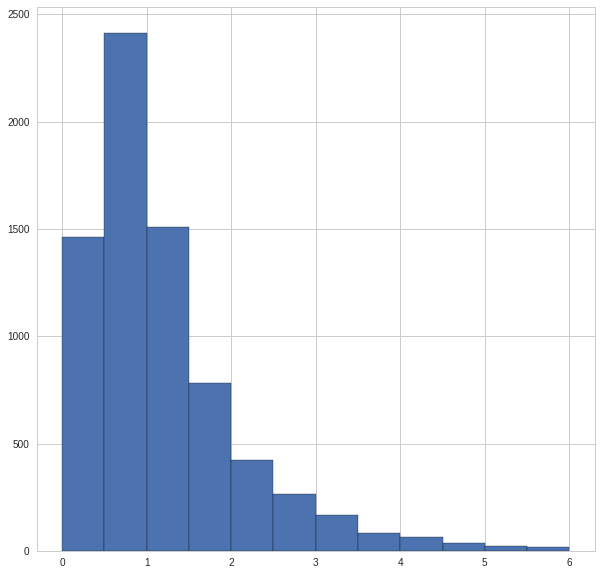

In [127]:
pl.figure(figsize=(10,10))
pl.hist(data['time_delta_spread']['pinnacle'], bins=12, edgecolor='black', range=(0, 6))

(array([  222.,  1803.,  2233., ...,    47.,    44.,    23.]),
 array([ 0. ,  0.5,  1. , ...,  5. ,  5.5,  6. ]),
 <a list of 12 Patch objects>)

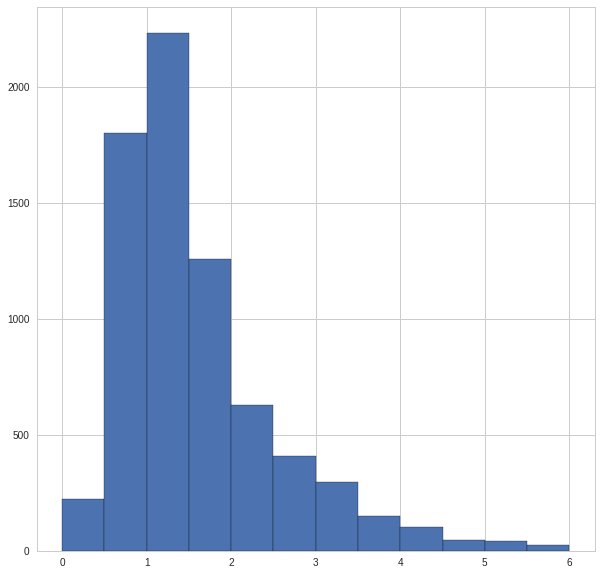

In [134]:
pl.figure(figsize=(10,10))
pl.hist(data['delta_spread']['pinnacle'], bins=12, edgecolor='black', range=(0, 6))

(array([  254.,  1600.,  1677., ...,   201.,    77.,    22.]),
 array([  0.,   2.,   4., ...,  16.,  18.,  20.]),
 <a list of 10 Patch objects>)

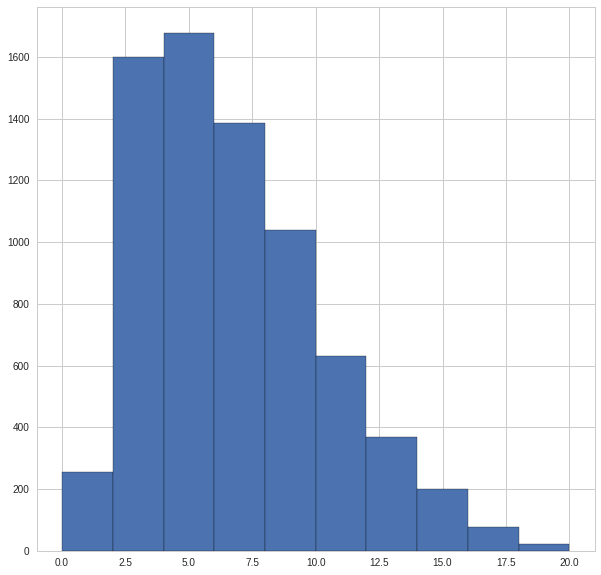

In [131]:
pl.figure(figsize=(10,10))
pl.hist(data['max_spread']['pinnacle'], bins=10, edgecolor='black', range=(0, 20))

(array([ 2025.,  3493.,  1036., ...,    14.,     7.,     5.]),
 array([  0.,   1.,   2., ...,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

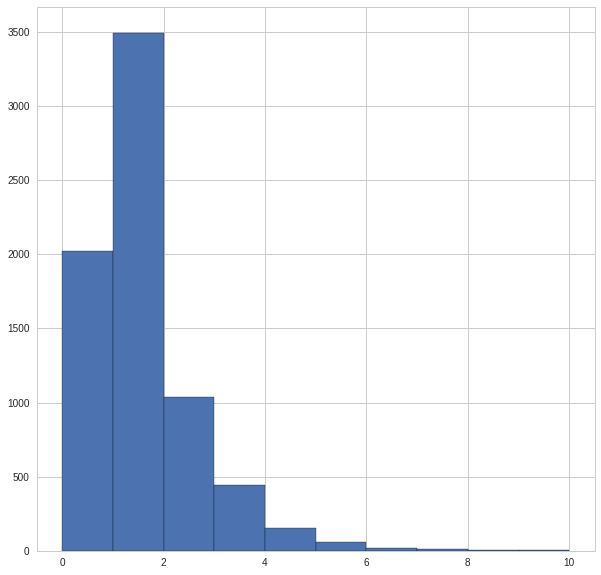

In [98]:
pl.figure(figsize=(10,10))
pl.hist(data['delta_spread']['pinnacle'], edgecolor='black', range=(0, 10))